In [1]:
import math
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
from matplotlib import figure

In [2]:
def Q_air_heating(G, t1, t2):
  # G м3/ч 
  # Q_air_heating кВт
  return round(0.278 * 1.21 * 1.005 * G * (t1-t2) / 1000, 0)


def G_air_heating(Q, t1, t2):
  # G м3/ч 
  # Q_air_heating кВт
  return int ((Q * 1000) / (0.278 * 1.21 * 1.005 * (t1-t2)) if t1 != t2 else 0)


def plot_df(df: pd.DataFrame, y_column, xtick_step, title='заголовок', value='показатель'):

    plt.figure(figsize=(24, 12), dpi=80)

    fig, ax1 = plt.subplots(1, figsize=(24,12))
    
    ax1.plot(df.index, df[y_column])
    ax1.set_xticks(df.index[::xtick_step])
    ax1.set_xticklabels(df.index[::xtick_step], rotation=90)

    plt.title(f"{title}")
    plt.xlabel('День')
    plt.ylabel(value)
    plt.grid(True)
    plt.legend()
    plt.show()

    # plt.savefig(name_output)
    # plt.close(fig)

In [3]:
df = pd.read_csv('weather_historicat_prepared.csv', index_col=['Time'])

In [4]:
df

,day,month,year,hour,T
Time,,,,,
09.01.2025_09:00,9,1,2025,09:00,-1.3
09.01.2025_06:00,9,1,2025,06:00,0.7
09.01.2025_03:00,9,1,2025,03:00,1.0
09.01.2025_00:00,9,1,2025,00:00,1.9
08.01.2025_21:00,8,1,2025,21:00,2.7
...,...,...,...,...,...
01.02.2005_15:00,1,2,2005,15:00,-6.6
01.02.2005_12:00,1,2,2005,12:00,-7.1
01.02.2005_09:00,1,2,2005,09:00,-8.6


In [5]:
Q_it = 700

#считаем что расход воздуха через стойки постоянный 
# с разницей температур 7гр
t_hot_corridor_max = 35
t_cold_corridor_max = 28
delta_t = t_hot_corridor_max - t_cold_corridor_max
hours_step = 3

G_it = G_air_heating(Q_it, t_hot_corridor_max, t_cold_corridor_max)

fun_G_m3_h_intake = 19000
fun_number_intake = G_it // fun_G_m3_h_intake
fun_kW_e_intake = 6 

fun_G_m3_h_exhaust = 19000
fun_number_exhaust = G_it // fun_G_m3_h_exhaust
fun_kW_e_exhaust = 6 



cooling_temp_needs = []

df['G_intake'] = df['T'].map(lambda x: abs(G_air_heating(Q_it, t_hot_corridor_max, x)) if abs(x - t_hot_corridor_max) > delta_t else G_it)


df['G_recircle'] = G_it - df['G_intake']
df['G_full'] = G_it
df['G_%'] = 100* df['G_recircle'] / df['G_full'] 


for index, row in df.iterrows():
    cooling_temp_needs.append(round(t_hot_corridor_max - row['T'] - delta_t, 2)) if row['G_recircle'] == 0 else cooling_temp_needs.append(0)

df['cooling_needs_temp'] = cooling_temp_needs
df['cooling_kW*h'] = df['cooling_needs_temp'].map(lambda x: abs(hours_step * 0.31 * 1.21 * 1.005 * G_it * (x) / 1000))

df['cooling_kW*h_standart'] = abs((hours_step * 0.31 * 1.21 * 1.005 * G_it * 10 )/ 1000)


df['IT_consume_kW*h'] = hours_step * Q_it

df['fan_in_kW*h'] = hours_step * fun_number_intake * fun_kW_e_intake # поддерживаем расход равный расходу вентиляторов в стойках 
df['fan_out_kW*h'] = df['G_intake'].map(lambda x: (math.ceil(x / fun_G_m3_h_exhaust) * fun_kW_e_exhaust * hours_step))  # расход выбрасываемого воздуха равен приточному уличному

df['PUE_cooling'] = (df['fan_out_kW*h'] + df['fan_in_kW*h'] + df['cooling_kW*h'] + df['IT_consume_kW*h']) / df['IT_consume_kW*h']

In [28]:
sum(df['cooling_kW*h'])

567599.5137252676

In [27]:
(sum(df['fan_in_kW*h']) + sum(df['fan_out_kW*h'] )) / sum(df['cooling_kW*h_standart']) 

0.1087250698366497

In [25]:
sum(df['cooling_kW*h_standart']) 

226046247.07921293

In [7]:
df_freecooling_with_adiabat = df.copy()

In [8]:

df_freecooling_with_adiabat = df_freecooling_with_adiabat.loc[df_freecooling_with_adiabat['cooling_needs_temp'] < 0]
df_freecooling_with_adiabat['cooling_temp_adiabatic'] = -5
df_freecooling_with_adiabat['cooling_temp_result'] = df_freecooling_with_adiabat['cooling_needs_temp'] - df_freecooling_with_adiabat['cooling_temp_adiabatic'] 

df_freecooling_with_adiabat['cooling_kW*h'] = df_freecooling_with_adiabat['cooling_temp_result'].map(lambda x: abs(hours_step * 0.31 * 1.21 * 1.005 * G_it * (x) / 1000))

In [9]:
sum(df_freecooling_with_adiabat.loc[df_freecooling_with_adiabat['cooling_temp_result'] < 0]['cooling_kW*h'])

28769.704827236998

In [10]:
df_freecooling_with_adiabat.loc[df_freecooling_with_adiabat['cooling_temp_result'] < 0]['cooling_kW*h'].describe()

count      51.000000
mean      564.111859
std       395.031623
min        33.453145
25%       183.992298
50%       602.156613
75%       786.148911
max      1605.750967
Name: cooling_kW*h, dtype: float64

In [11]:
df['cooling_kW*h'].describe()

count    67571.000000
mean         8.400046
std         98.595159
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3278.408224
Name: cooling_kW*h, dtype: float64

In [12]:
df.PUE_cooling.describe()

count    67571.000000
mean         1.177200
std          0.058471
min          1.145714
25%          1.162857
50%          1.162857
75%          1.180000
max          2.826861
Name: PUE_cooling, dtype: float64

In [13]:
df.loc[df['PUE_cooling'] > 1.2]

,day,month,year,hour,T,G_intake,G_recircle,G_full,G_%,cooling_needs_temp,cooling_kW*h,cooling_kW*h_standart,IT_consume_kW*h,fan_in_kW*h,fan_out_kW*h,PUE_cooling
Time,,,,,,,,,,,,,,,,
28.09.2024_18:00,28,9,2024,18:00,22.3,163041,132762,295803,44.881898,0.0,0.0,3345.314515,2100,270,162,1.205714
28.09.2024_15:00,28,9,2024,15:00,22.0,159278,136525,295803,46.154028,0.0,0.0,3345.314515,2100,270,162,1.205714
26.09.2024_15:00,26,9,2024,15:00,22.6,166986,128817,295803,43.548240,0.0,0.0,3345.314515,2100,270,162,1.205714
25.09.2024_15:00,25,9,2024,15:00,23.1,174002,121801,295803,41.176391,0.0,0.0,3345.314515,2100,270,180,1.214286
21.09.2024_15:00,21,9,2024,15:00,21.9,158063,137740,295803,46.564775,0.0,0.0,3345.314515,2100,270,162,1.205714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18.05.2005_18:00,18,5,2005,18:00,22.9,171126,124677,295803,42.148660,0.0,0.0,3345.314515,2100,270,180,1.214286
18.05.2005_15:00,18,5,2005,15:00,23.1,174002,121801,295803,41.176391,0.0,0.0,3345.314515,2100,270,180,1.214286
18.05.2005_12:00,18,5,2005,12:00,23.0,172552,123251,295803,41.666582,0.0,0.0,3345.314515,2100,270,180,1.214286


In [14]:
df.describe()

,day,month,year,T,G_intake,G_recircle,G_full,G_%,cooling_needs_temp,cooling_kW*h,cooling_kW*h_standart,IT_consume_kW*h,fan_in_kW*h,fan_out_kW*h,PUE_cooling
count,67571.000000,67571.000000,67571.000000,67571.000000,67571.00000,67571.00000,67571.0,67571.000000,67571.000000,67571.000000,6.757100e+04,67571.0,67571.0,67571.000000,67571.000000
mean,15.717305,6.460212,2014.527179,6.813700,89153.13161,206649.86839,295803.0,69.860640,-0.025110,8.400046,3.345315e+03,2100.0,270.0,93.719554,1.177200
std,8.807127,3.460609,5.335089,10.790217,48227.95001,48227.95001,0.0,16.304077,0.294726,98.595159,1.364252e-12,0.0,0.0,45.739977,0.058471
min,1.000000,1.000000,2005.000000,-30.500000,31612.00000,0.00000,295803.0,0.000000,-9.800000,0.000000,3.345315e+03,2100.0,270.0,36.000000,1.145714
25%,8.000000,3.000000,2010.000000,-0.700000,58000.00000,190696.00000,295803.0,64.467230,0.000000,0.000000,3.345315e+03,2100.0,270.0,72.000000,1.162857
50%,16.000000,6.000000,2014.000000,6.300000,72147.00000,223656.00000,295803.0,75.609781,0.000000,0.000000,3.345315e+03,2100.0,270.0,72.000000,1.162857
75%,23.000000,9.000000,2019.000000,15.300000,105107.00000,237803.00000,295803.0,80.392356,0.000000,0.000000,3.345315e+03,2100.0,270.0,108.000000,1.180000
max,31.000000,12.000000,2025.000000,37.800000,295803.00000,264191.00000,295803.0,89.313158,0.000000,3278.408224,3.345315e+03,2100.0,270.0,288.000000,2.826861


In [15]:
sum(df['cooling_kW*h'])

567599.5137252676

In [16]:
df.loc[df['cooling_kW*h'] > 0].count()

day                      866
month                    866
year                     866
hour                     866
T                        866
G_intake                 866
G_recircle               866
G_full                   866
G_%                      866
cooling_needs_temp       866
cooling_kW*h             866
cooling_kW*h_standart    866
IT_consume_kW*h          866
fan_in_kW*h              866
fan_out_kW*h             866
PUE_cooling              866
dtype: int64

In [17]:
df.loc[df['PUE_cooling'] > 1.2].count()

day                      6169
month                    6169
year                     6169
hour                     6169
T                        6169
G_intake                 6169
G_recircle               6169
G_full                   6169
G_%                      6169
cooling_needs_temp       6169
cooling_kW*h             6169
cooling_kW*h_standart    6169
IT_consume_kW*h          6169
fan_in_kW*h              6169
fan_out_kW*h             6169
PUE_cooling              6169
dtype: int64

In [18]:
sum(df['cooling_kW*h']) 

567599.5137252676

C:\Users\MID\AppData\Local\Temp\ipykernel_27376\74431229.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1920x960 with 0 Axes>

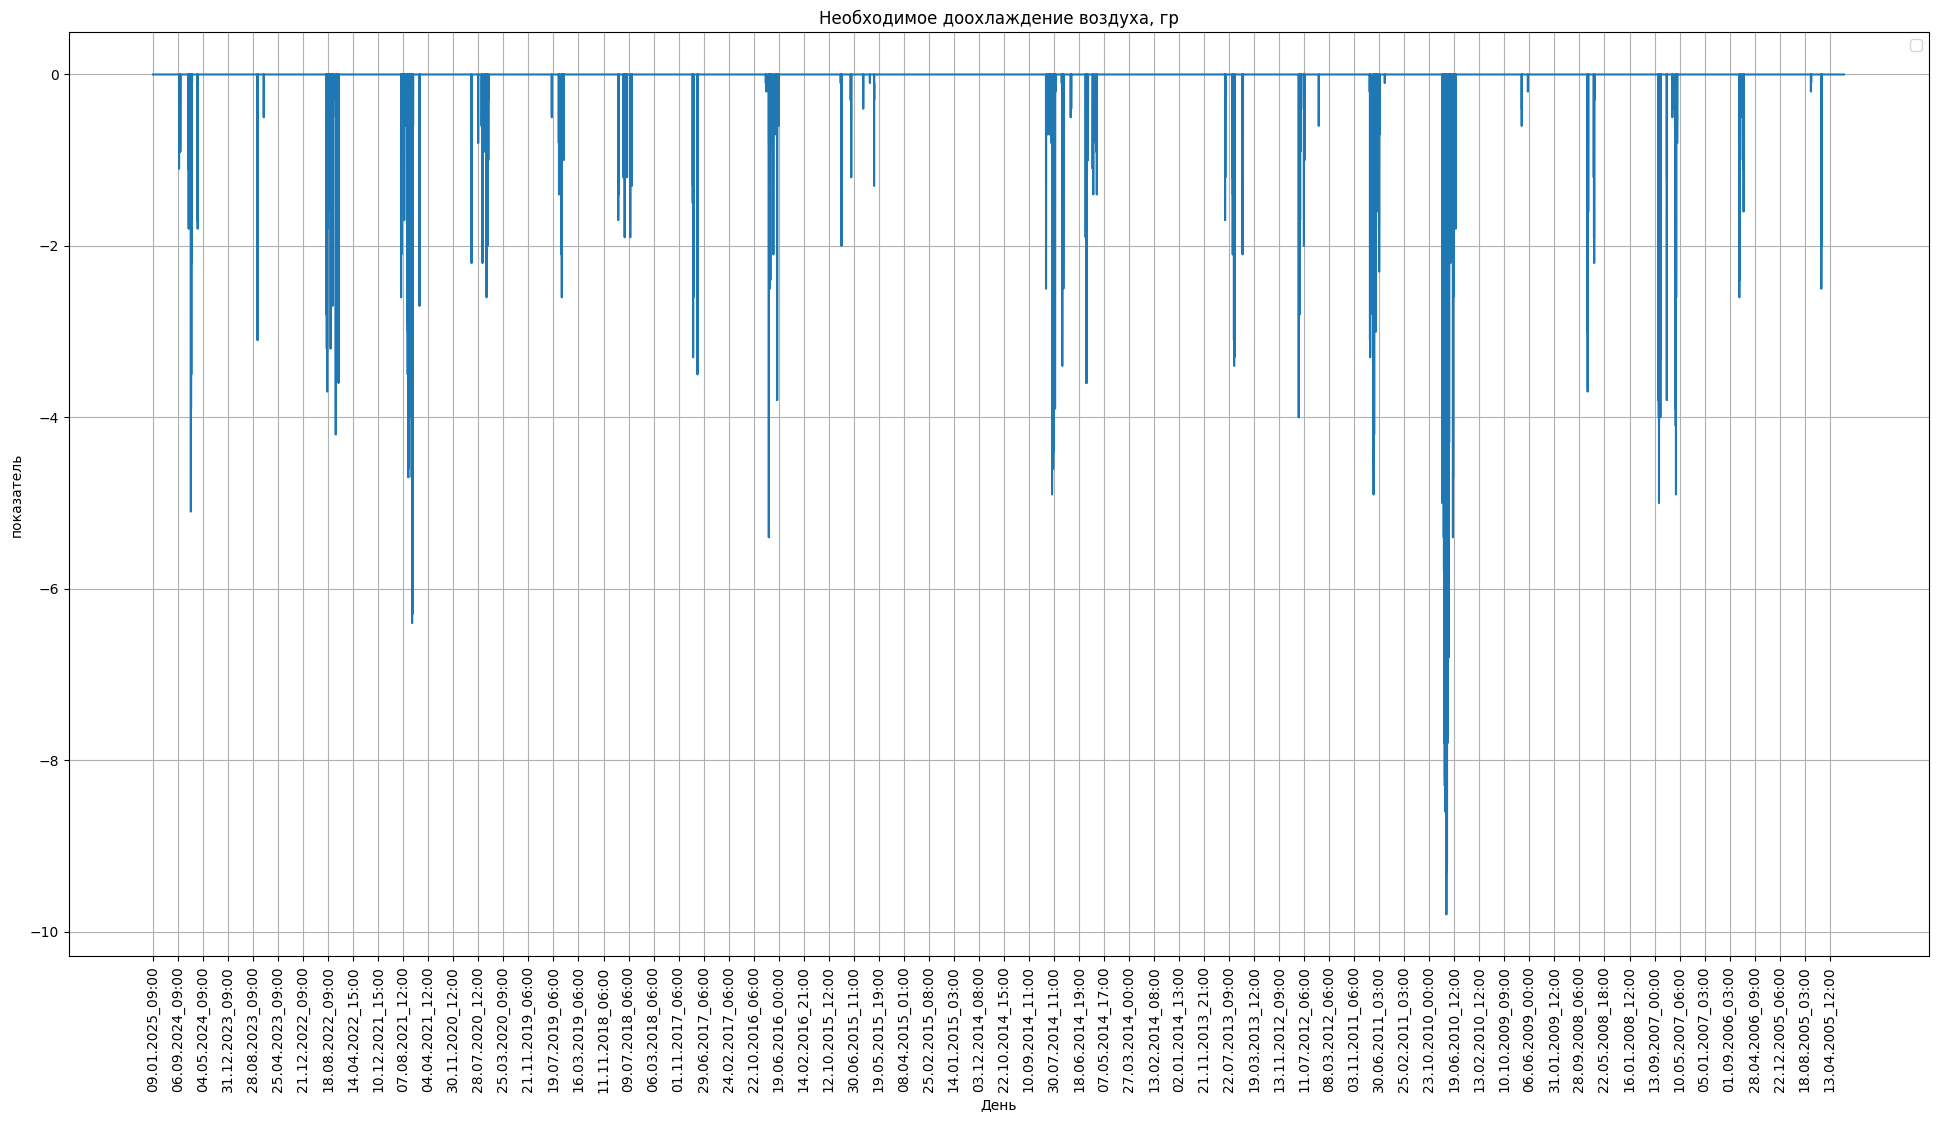

In [19]:
plot_df(df, 'cooling_needs_temp', 1000, 'Необходимое доохлаждение воздуха, гр')

C:\Users\MID\AppData\Local\Temp\ipykernel_27376\74431229.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1920x960 with 0 Axes>

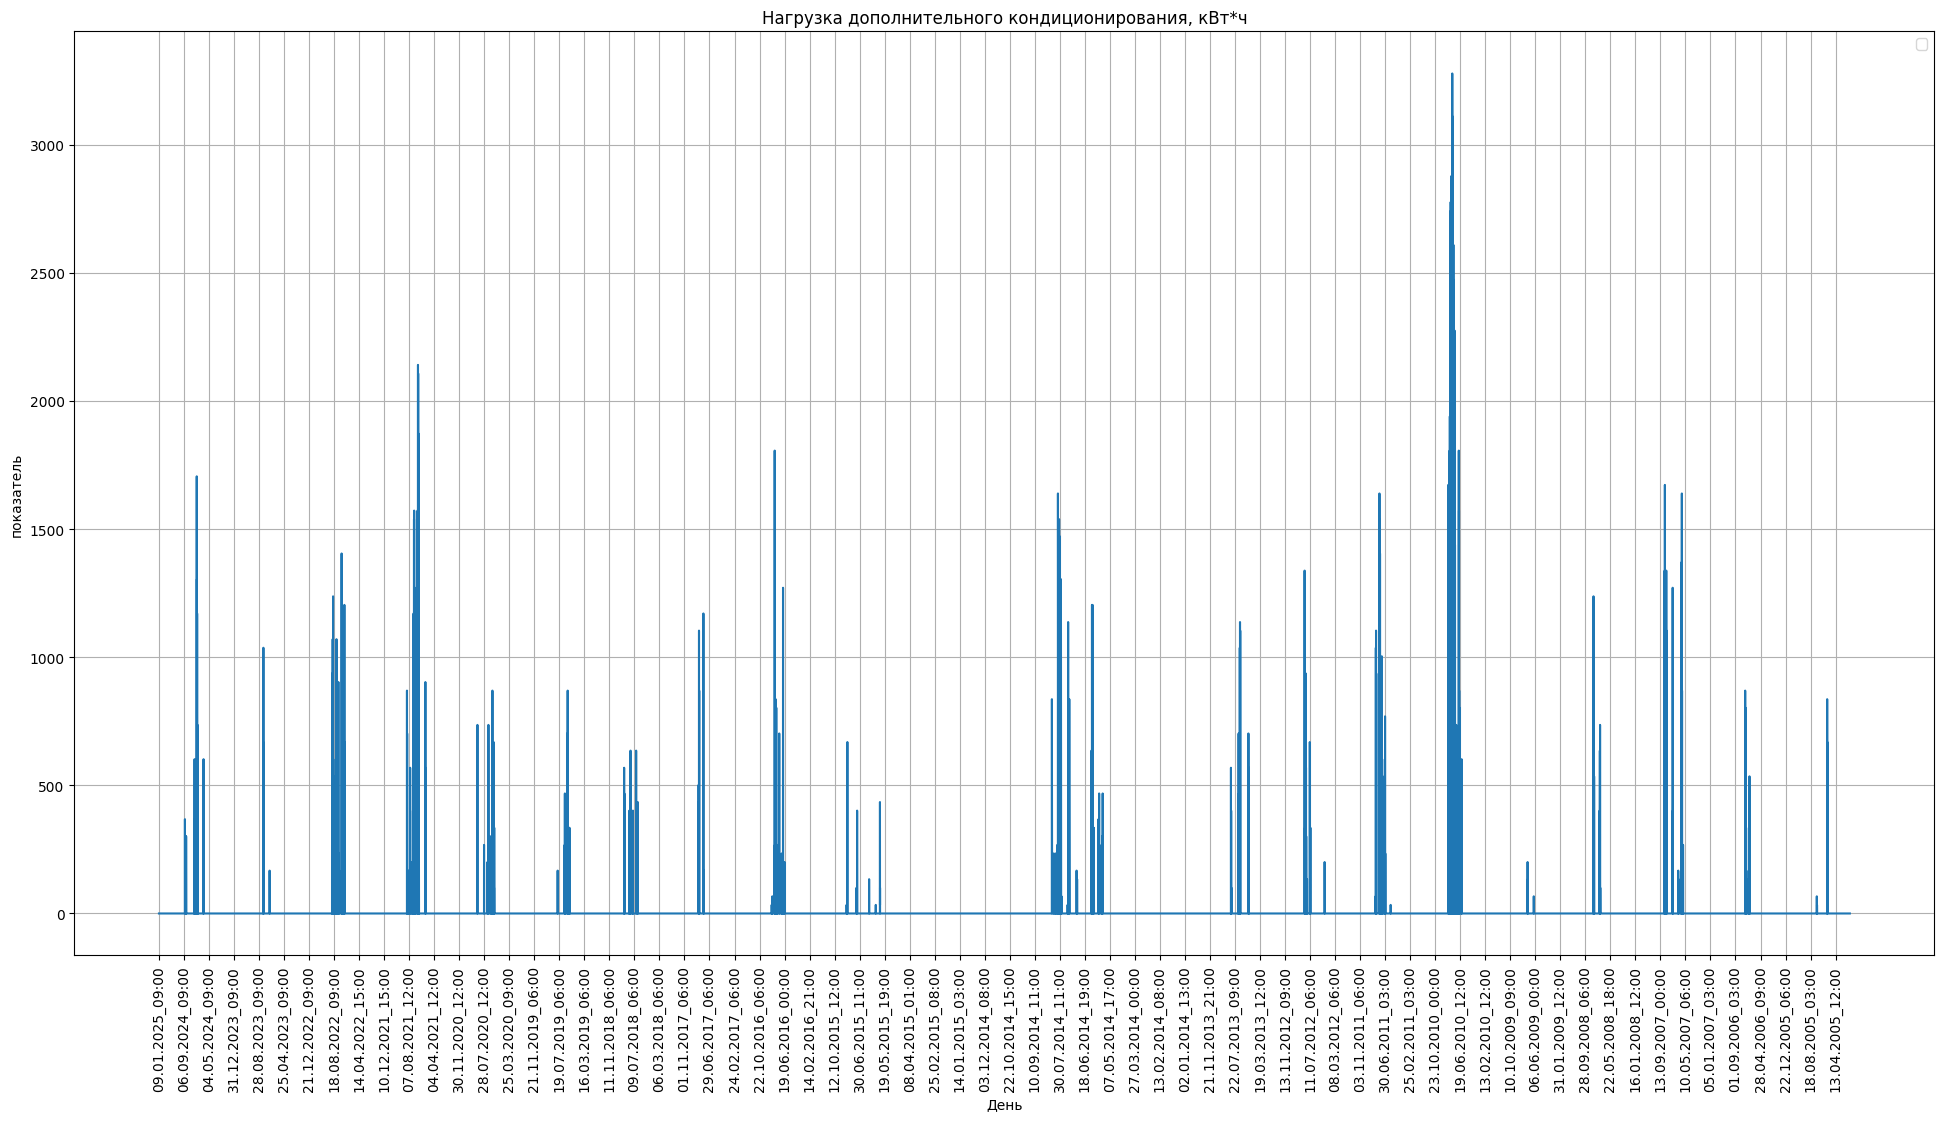

In [20]:
plot_df(df, 'cooling_kW*h', 1000,  'Нагрузка дополнительного кондиционирования, кВт*ч')

C:\Users\MID\AppData\Local\Temp\ipykernel_27376\74431229.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1920x960 with 0 Axes>

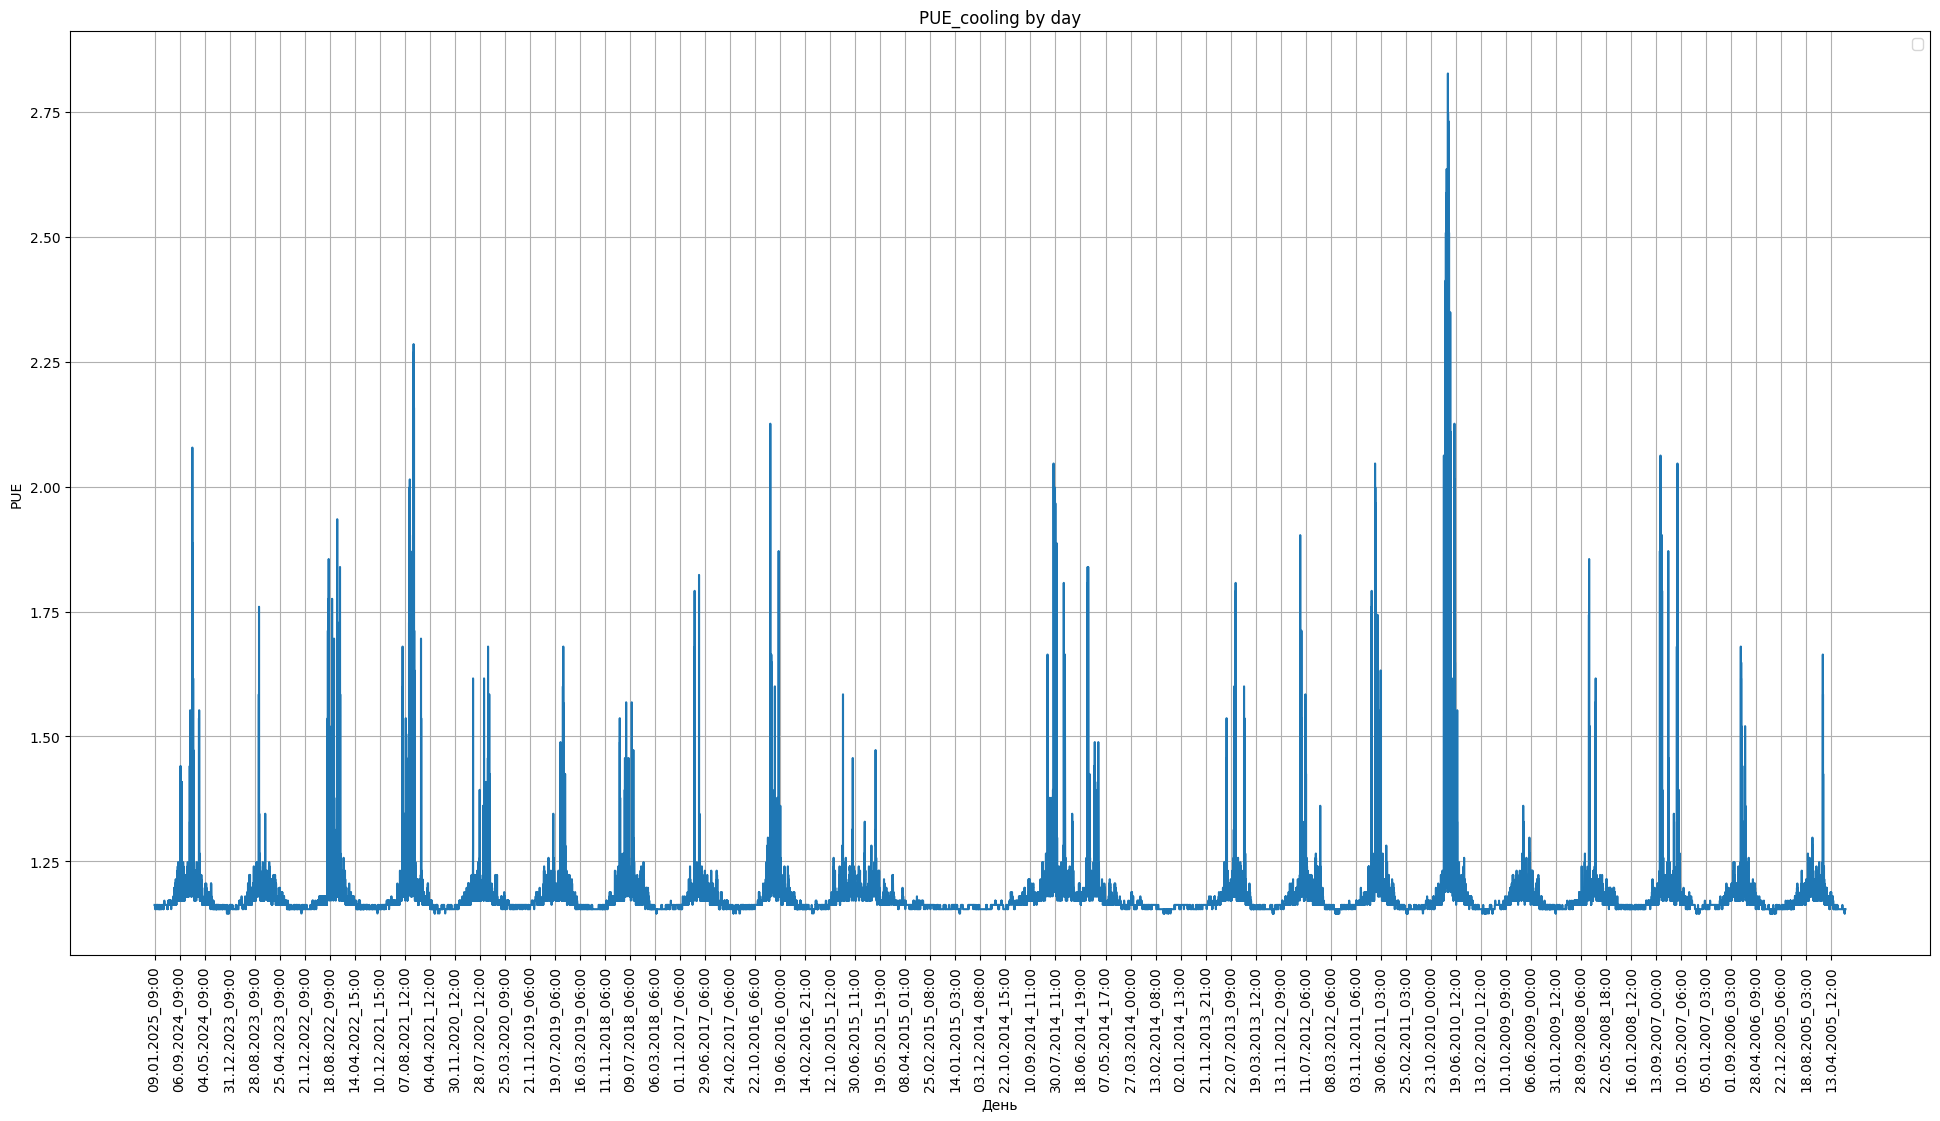

In [21]:
plot_df(df,'PUE_cooling', 1000, 'PUE_cooling by day', 'PUE')

In [22]:
print(f"min PUE_cooling - {df['PUE_cooling'].min()}" )
print(f"mean PUE_cooling - {df['PUE_cooling'].mean()}" )
print(f"max PUE_cooling - {df['PUE_cooling'].max()}" )
print(f"variance PUE_cooling - {df['PUE_cooling'].var()}" )
print(f"std PUE_cooling - {df['PUE_cooling'].std()}" )

min PUE_cooling - 1.1457142857142857
mean PUE_cooling - 1.1771998096797318
max PUE_cooling - 2.826861059285286
variance PUE_cooling - 0.0034188500434442787
std PUE_cooling - 0.058470933321132124


In [23]:
print(f" PUE < 1.2 --- {len(df.loc[df['PUE_cooling'] < 1.2]) / len(df.loc[df['PUE_cooling'] > 1.0]) * 100} %")
print(f" PUE < 1.4 --- {len(df.loc[df['PUE_cooling'] < 1.4]) / len(df.loc[df['PUE_cooling'] > 1.0]) * 100} %")

 PUE < 1.2 --- 90.87034378653564 %
 PUE < 1.4 --- 99.14608337896435 %


In [24]:
print(f"Мощность системы охлаждения одного блока по quantile(0.5) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.5) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.6) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.6) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.7) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.7) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.8) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.8) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.9) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.9) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по quantile(0.99) значению - { int(df.loc[df['cooling_kW*h'] > 0.0]['cooling_kW*h'].quantile(0.99) / hours_step)} кВт" )
print(f"Мощность системы охлаждения одного блока по max значению - {int(df['cooling_kW*h'].max() / hours_step)} кВт" )

Мощность системы охлаждения одного блока по quantile(0.5) значению - 167 кВт
Мощность системы охлаждения одного блока по quantile(0.6) значению - 223 кВт
Мощность системы охлаждения одного блока по quantile(0.7) значению - 278 кВт
Мощность системы охлаждения одного блока по quantile(0.8) значению - 356 кВт
Мощность системы охлаждения одного блока по quantile(0.9) значению - 479 кВт
Мощность системы охлаждения одного блока по quantile(0.99) значению - 869 кВт
Мощность системы охлаждения одного блока по max значению - 1092 кВт
